In [1]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

 

     |████████████████████████████████| 993kB 9.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
download = drive.CreateFile({'id':'1pfS5p7CEdCPvc8kiQ7njwEJj2vc4c_Xn'})
download.GetContentFile('train_dataset.csv')

In [0]:

download = drive.CreateFile({'id':'1tpSU2dbKlG6vtRWz-XnLv_ZUMVpMarD_'})
download.GetContentFile('test_dataset.csv')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [0]:

train=pd.read_csv("train_dataset.csv")
test=pd.read_csv("test_dataset.csv")

In [58]:
train.head()

,ID,Essayset,min_score,max_score,score_1,score_2,score_3,score_4,score_5,clarity,coherent,EssayText
0,1,1.0,0,3,1,1,1.0,1.0,1.0,average,worst,Some additional information that we would need...
1,2,1.0,0,3,1,1,NaN,1.5,1.0,excellent,worst,"After reading the expirement, I realized that ..."
2,3,1.0,0,3,1,1,1.0,1.0,1.5,worst,above_average,"What you need is more trials, a control set up..."
3,4,1.0,0,3,0,0,0.0,0.0,1.0,worst,worst,The student should list what rock is better an...
4,5,1.0,0,3,2,2,2.0,2.5,1.0,above_average,worst,For the students to be able to make a replicat...


In [60]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = text.replace('48(DEG)C', '')

    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

In [0]:
train['EssayText'] = train['EssayText'].apply(clean_text)
train['EssayText'] = train['EssayText'].str.replace(' #1-3', '')

In [0]:
test['EssayText'] = test['EssayText'].apply(clean_text)
test['EssayText'] = test['EssayText'].str.replace(' #1-3', '')

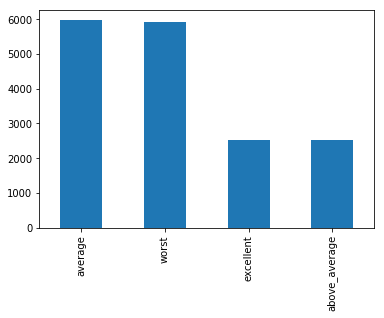

In [64]:

train['clarity'].value_counts().plot.bar()

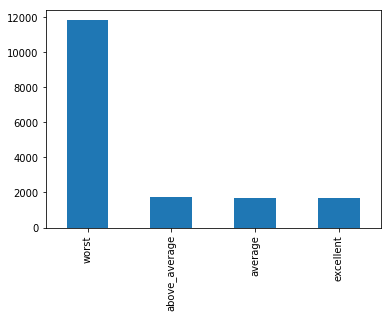

In [65]:



train['coherent'].value_counts().plot.bar()

In [0]:


essayscore=round((train['score_1']+train['score_2']+train['score_3']+train['score_4']+train['score_5'])/5)

In [0]:
train['essay_score']=round(essayscore,0)

In [68]:

train['essay_score'].unique()

array([ 1., nan,  0.,  2.,  3.])

In [0]:
train_length=train['EssayText'].value_counts()

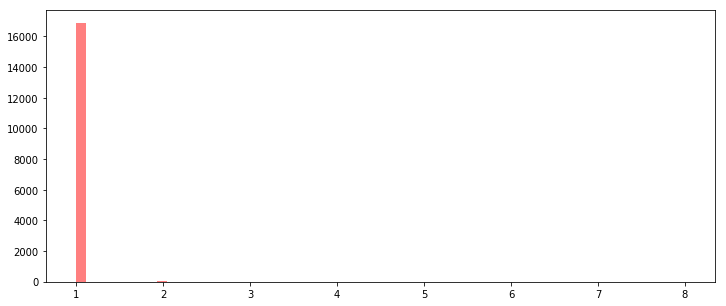

In [70]:
plt.figure(figsize = (12, 5))
plt.hist(train_length, bins = 60, alpha = 0.5, color = 'r')
plt.show()

In [71]:

print("max length : ", np.max(train_length))
print("min length : ", np.min(train_length))
print("mean length : ", np.mean(train_length))
print("75 % percentile : ", np.percentile(train_length, 75))
print("85 % percentile : ", np.percentile(train_length, 85))
print("std length : ", np.std(train_length))

max length :  8
min length :  1
mean length :  1.0059021424777195
75 % percentile :  1.0
85 % percentile :  1.0
std length :  0.12132815381625495


In [72]:
print(train.EssayText.isna().sum())
print(test.EssayText.isna().sum())

0
0


In [0]:
mylist=["clarity","coherent"]
dummies=pd.get_dummies(train[mylist], prefix=mylist)
train.drop(mylist, axis=1, inplace=True)
train=pd.concat([train,dummies], axis=1)

In [0]:
mylist1=["clarity","coherent"]
dummies1=pd.get_dummies(test[mylist1], prefix=mylist1)
test.drop(mylist1, axis=1, inplace=True)
test=pd.concat([test,dummies1], axis=1)

In [0]:
train_df=train.drop(['score_1','score_2','score_3','score_4','score_5'],axis=1)



In [0]:
train_df=train_df.dropna()

In [0]:

from keras.utils import to_categorical
#y=train_df['essay_score']
y=to_categorical(train_df['essay_score'])

X=train_df.drop(["essay_score","ID"],axis=1)

In [78]:
X.shape

(16459, 12)

In [79]:
test.columns

Index(['ID', 'Essayset', 'min_score', 'max_score', 'EssayText',
       'clarity_above_average', 'clarity_average', 'clarity_excellent',
       'clarity_worst', 'coherent_above_average', 'coherent_average',
       'coherent_excellent', 'coherent_worst'],
      dtype='object')

In [0]:
test_df=test.drop(["ID"],axis=1)

In [81]:
test_df.shape

(5224, 12)

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2018)

In [0]:
from keras.preprocessing.text import Tokenizer
max_features = 10000
tokenizer = Tokenizer(num_words=max_features,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(list(X_train['EssayText']))
X_train['EssayText'] = tokenizer.texts_to_sequences(X_train['EssayText'])
X_test ['EssayText']= tokenizer.texts_to_sequences(X_test['EssayText'])

In [0]:
tokenizer = Tokenizer(num_words=max_features,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(list(test_df['EssayText']))
test_df['EssayText'] = tokenizer.texts_to_sequences(test_df['EssayText'])

In [85]:

from keras.preprocessing import sequence
max_words = 50
X_train['EssayText'] = sequence.pad_sequences(X_train['EssayText'], maxlen=max_words)
X_test['EssayText'] = sequence.pad_sequences(X_test['EssayText'], maxlen=max_words)
print(X_train.shape,y_test.shape)

(13167, 12) (3292, 4)


In [0]:
test_df['EssayText'] = sequence.pad_sequences(test_df['EssayText'], maxlen=max_words)

In [0]:

max_features = 10000
embed_size = 32
EMBEDDING_DIM=50

In [0]:
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,GRU
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

In [97]:
model = Sequential()
model.add(Embedding(max_features, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(250, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 120

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 11850 samples, validate on 1317 samples
Epoch 1/20
11850/11850 [==============================] - 5s 390us/step - loss: 1.0826 - acc: 0.4707 - val_loss: 0.8062 - val_acc: 0.6629
Epoch 2/20
11850/11850 [==============================] - 3s 222us/step - loss: 0.8066 - acc: 0.6408 - val_loss: 0.7723 - val_acc: 0.6446
Epoch 3/20
11850/11850 [==============================] - 2s 202us/step - loss: 0.7674 - acc: 0.6513 - val_loss: 0.7206 - val_acc: 0.6644
Epoch 4/20
11850/11850 [==============================] - 2s 202us/step - loss: 0.7452 - acc: 0.6441 - val_loss: 0.7119 - val_acc: 0.6636
Epoch 5/20
11850/11850 [==============================] - 2s 203us/step - loss: 0.7248 - acc: 0.6508 - val_loss: 0.6872 - val_acc: 0.6477
Epoch 6/20
11850/11850 [==============================] - 2s 202us/step - loss: 0.7094 - acc: 0.6524 - val_loss: 0.6710 - val_acc: 0.6629
Epoch 7/20
11850/11850 [==============================] - 2s 201us/step - loss: 0.6996 - acc: 0.6593 - val_loss: 0.6601 - v

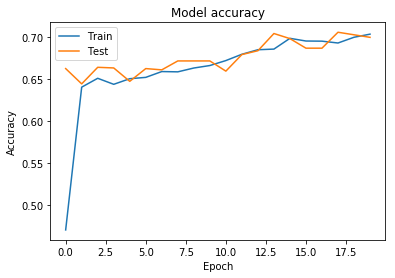

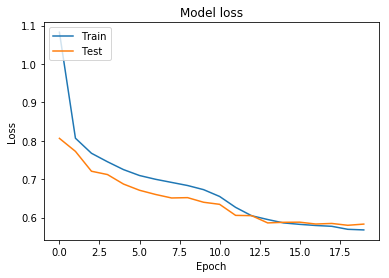

In [99]:
import matplotlib.pyplot as plot
plot.plot(history.history['acc'])
plot.plot(history.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')

plot.show()

plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [98]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 71.14%


In [0]:
pred=model.predict(test_df)

In [0]:
pred

array([[5.5188042e-01, 4.4307995e-01, 5.0388970e-03, 7.4491726e-07],
       [5.5188042e-01, 4.4307995e-01, 5.0388970e-03, 7.4491726e-07],
       [2.5937426e-05, 1.3766013e-02, 5.4927713e-01, 4.3693092e-01],
       ...,
       [3.7394851e-01, 6.1534750e-01, 1.0703712e-02, 2.8328054e-07],
       [3.7394851e-01, 6.1534750e-01, 1.0703712e-02, 2.8328054e-07],
       [3.7394851e-01, 6.1534750e-01, 1.0703712e-02, 2.8328054e-07]],
      dtype=float32)

In [0]:
t=np.argmax(pred, axis=1)

In [0]:
maxlen=12

In [0]:
Submission=pd.DataFrame({"id":test["ID"],"essay_set":test['Essayset'],"essay_score":t})

In [0]:

Submission.to_csv('Lstm.csv', header=True, index=False)


from google.colab import files
files.download('Lstm.csv') 

In [0]:
Submission.head()

,id,essay_set,essay_score
0,1673,1,1
1,1674,1,1
2,1675,1,2
3,1676,1,0
4,1677,1,0
